In [73]:
# from IPython.core.interactiveshell import InteractiveShell
import sys; sys.path.insert(0, '..')
# # PyTorch
from torchvision import transforms, datasets
#import torch
from torch import optim, cuda
from torch.utils.data import DataLoader
# import torch.nn as nn

from sklearn.metrics import confusion_matrix
# import warnings
# warnings.filterwarnings('ignore', category=FutureWarning)

# # Data science tools
# import numpy as np
import pandas as pd
import os

# # Image manipulations
# from PIL import Image
# # Useful for examining network
# # Timing utility
# from timeit import default_timer as timer

# # Visualizations
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.rcParams['font.size'] = 14

# # Printing out all outputs
# InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_rows', None)

In [2]:
from src.helper import load_checkpoint
from src.make_predictions import *

Train on gpu: False


In [60]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu = cuda.is_available()
print('Train on gpu: {}'.format(train_on_gpu))

batch_size=64

Train on gpu: False


In [61]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.RandomRotation(15, resample=Image.BILINEAR),
        #transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        
        #transforms.Lambda(lambda x: x.repeat(3,1,1)),
        #transforms.Normalize([0.5], [0.5])
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
       
        #transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
#         'test': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.Grayscale(num_output_channels=3),
#         transforms.ToTensor(),
       
#         #transforms.Lambda(lambda x: x.repeat(3,1,1)),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
}


# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=data_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=data_transforms['val']),
#     'test':
#     datasets.ImageFolder(root=testdir, transform=data_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
#     'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [4]:

# data_dir = '../data/processed/places_boer/output/'

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# class_names = image_datasets['train'].classes
# n_classes = len(class_names)

# # Create training and validation dataloaders
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], num_workers=8, batch_size=64, shuffle=True) for x in ['train', 'val']}

In [4]:
# Location of data

model_dir = '../models/'
data_dir = '../data/processed/places_boer/output/'

traindir = data_dir + 'train/'
validdir = data_dir + 'val/'
testdir = data_dir + 'test/'

save_file_name = model_dir + 'resnet50-deboer.pth'
checkpoint_path = model_dir + 'resnet50-deboer.pth'


## Inspect training data

TODO: change something about train/val division

In [63]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
#n_test = []


# Iterate through each category
for d in os.listdir(traindir):
    if len(os.listdir(traindir + d)) > 0:
        
        categories.append(d)

        # Number of each image
        train_imgs = os.listdir(traindir + d)
        valid_imgs = os.listdir(validdir + d)
        #test_imgs = os.listdir(testdir + d)
        n_train.append(len(train_imgs))
        n_valid.append(len(valid_imgs))
        #n_test.append(len(test_imgs))



# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid}).sort_values('category')


cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head(15)


,category,n_train,n_valid
61,soccer,416,10
93,construction_site,396,10
52,ceremony,292,10
79,portrait_group,255,10
54,music_performance,240,10
110,street,221,10
22,building_facade,210,10
32,boats,206,10
80,crowd,197,10
100,saint_niclaus,189,10


In [64]:
cat_df.tail(15)

,category,n_train,n_valid
118,nursery,9,10
101,airplane,9,9
76,movie_set,8,9
11,fishing,8,9
131,repair_shop,8,9
43,factory_outdoor,7,8
51,amusement_park,7,7
15,river,7,8
33,garbage_dump,6,7
104,boxing_ring,6,7


In [6]:
n_classes = len(cat_df)
print('There are {} different classes.'.format(n_classes))

There are 134 different classes.


## Load model 

In [7]:
model, optimizer = load_checkpoint(path=checkpoint_path)

resnet50


/Users/melvinwevers/virtualenvs/hisvis/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/melvinwevers/virtualenvs/hisvis/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


total parameters: 24067014
total_trainable_params: 558982


NameError: name 'data_transforms' is not defined

In [10]:
# criterion = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters())

NameError: name 'model' is not defined

In [8]:
# def imshow_tensor(image, ax=None, title=None):
#     """Imshow for Tensor."""

#     if ax is None:
#         fig, ax = plt.subplots()

#     # Set the color channel as the third dimension
#     image = image.numpy().transpose((1, 2, 0))

#     # Reverse the preprocessing steps
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     image = std * image + mean

#     # Clip the image pixel values
#     image = np.clip(image, 0, 1)

#     ax.imshow(image)
#     plt.axis('off')

#     return ax, image



# def process_image(image_path):
#     """Process an image path into a PyTorch tensor"""

#     image = Image.open(image_path)
#     # Resize
#     img = image.resize((256, 256))

#     # Center crop
#     width = 256
#     height = 256
#     new_width = 224
#     new_height = 224

#     left = (width - new_width) / 2
#     top = (height - new_height) / 2
#     right = (width + new_width) / 2
#     bottom = (height + new_height) / 2
#     img = img.crop((left, top, right, bottom))

#     # Convert to numpy, transpose color dimension and normalize
#     img = np.array(img)
#     img = np.array(img)
#     if img.ndim == 3:
#         pass
#     else:
#         img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
#     img = img.transpose((2, 0, 1)) / 256
    

#     #Standardization
#     means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
#     stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

#     img = img - means
#     img = img / stds

#     img_tensor = torch.Tensor(img)

#     return img_tensor



# def predict(image_path, model, topk=5):
#     """Make a prediction for an image using a trained model

#     Params
#     --------
#         image_path (str): filename of the image
#         model (PyTorch model): trained model for inference
#         topk (int): number of top predictions to return

#     Returns

#     """
#     real_class = image_path.split('/')[-2]

#     # Convert to pytorch tensor
#     img_tensor = process_image(image_path)

#     # Resize
#     if train_on_gpu:
#         img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
#     else:
#         img_tensor = img_tensor.view(1, 3, 224, 224)

#     # Set to evaluation
#     with torch.no_grad():
#         model.eval()
#         # Model outputs log probabilities
#         out = model(img_tensor)
#         ps = torch.exp(out)

#         # Find the topk predictions
#         topk, topclass = ps.topk(topk, dim=1)

#         # Extract the actual classes and probabilities
#         top_classes = [
#             model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
#         ]
#         top_p = topk.cpu().numpy()[0]

#         return img_tensor.cpu().squeeze(), top_p, top_classes, real_class






# def random_test_image():
#     """Pick a random test image from the test directory"""
#     c = np.random.choice(cat_df['category'])
#     root = validdir + c + '/'
#     img_path = root + np.random.choice(os.listdir(root))
#     print(img_path)
#     return img_path


# def display_prediction(image_path, model, topk):
#     """Display image and preditions from model"""

#     # Get predictions
#     img, ps, classes, y_obs = predict(image_path, model, topk)
#     # Convert results to dataframe for plotting
#     result = pd.DataFrame({'p': ps}, index=classes)

#     # Show the image
#     plt.figure(figsize=(16, 5))
#     ax = plt.subplot(1, 2, 1)
#     ax, img = imshow_tensor(img, ax=ax)

#     # Set title to be the actual class
#     ax.set_title(y_obs, size=20)

#     ax = plt.subplot(1, 2, 2)
#     # Plot a bar plot of predictions
#     result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
#     plt.xlabel('Predicted Probability')
#     plt.tight_layout()



# make predictions

../data/processed/places_boer/output/val/waterfront/NL-HlmNHA_1478_09979_02_G.jpg


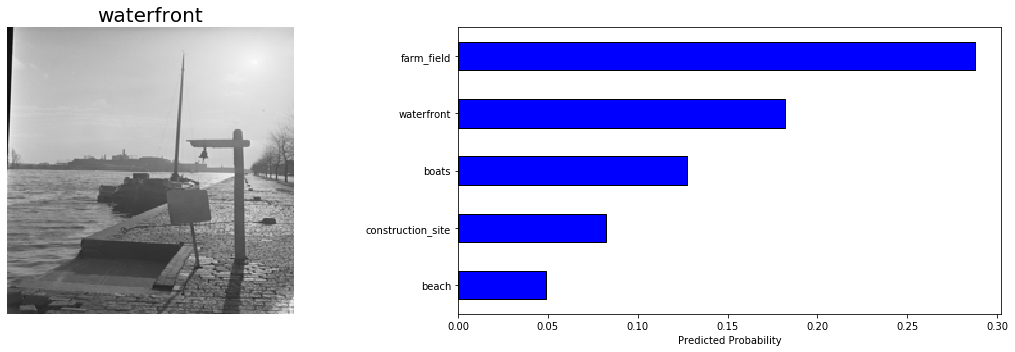

In [18]:
display_prediction(random_test_image(validdir, cat_df['category']), model, topk=5)

## Model Performance

In [43]:
results = pd.read_csv('../data/processed/results.csv',skiprows=[1])
results.columns = ['category', 'top1_acc', 'top5_acc', 'loss']

In [47]:
results

,category,top1_acc,top5_acc,loss
0,accident_stretcher,0.000000,50.000000,4.168619
1,accident_train,80.000000,90.000000,0.810440
2,aerial,80.000000,100.000000,0.532172
3,airplane,22.222222,22.222222,3.726858
4,amphitheater,50.000000,70.000000,2.325623
5,amusement_park,0.000000,0.000000,5.631059
6,animals_cow,20.000000,50.000000,3.362650
7,animals_dog,10.000000,50.000000,3.276575
8,animals_horse,70.000000,80.000000,1.343422
9,animals_misc,20.000000,70.000000,3.025502


In [72]:
nb_classes = n_classes

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

KeyboardInterrupt: 

## Make a confusion matrix
This is a slow process on a cpu, I provided predictions

In [48]:
def predictions():  
    y_pred = []
    y_true = []
    with torch.no_grad():

        # Testing loop
        for data, targets in dataloaders['val']:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                output = pred.unsqueeze(0).to('cuda') 
                target = true.unsqueeze(0).to('cuda')

                pred = output.topk(1, dim=1, largest=True, sorted=True)[1]
                y_pred.append(pred.item())
                y_true.append(true.item())
    return y_pred, y_true 
           
            
    

In [79]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'# Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    fig, ax = plt.subplots(figsize=(50,50))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')# Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")# Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('../output/figures/confusion_matrix.png', dpi=300)
    return ax


In [80]:
#y_true, y_pred = predictions()
predictions_df = pd.read_csv('../data/processed/predictions.csv')

Normalized confusion matrix
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.1 0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.7 ... 0.  0.  0. ]
 ...
 [0.1 0.  0.  ... 0.2 0.  0. ]
 [0.  0.  0.  ... 0.  0.2 0. ]
 [0.  0.  0.  ... 0.  0.  0.7]]


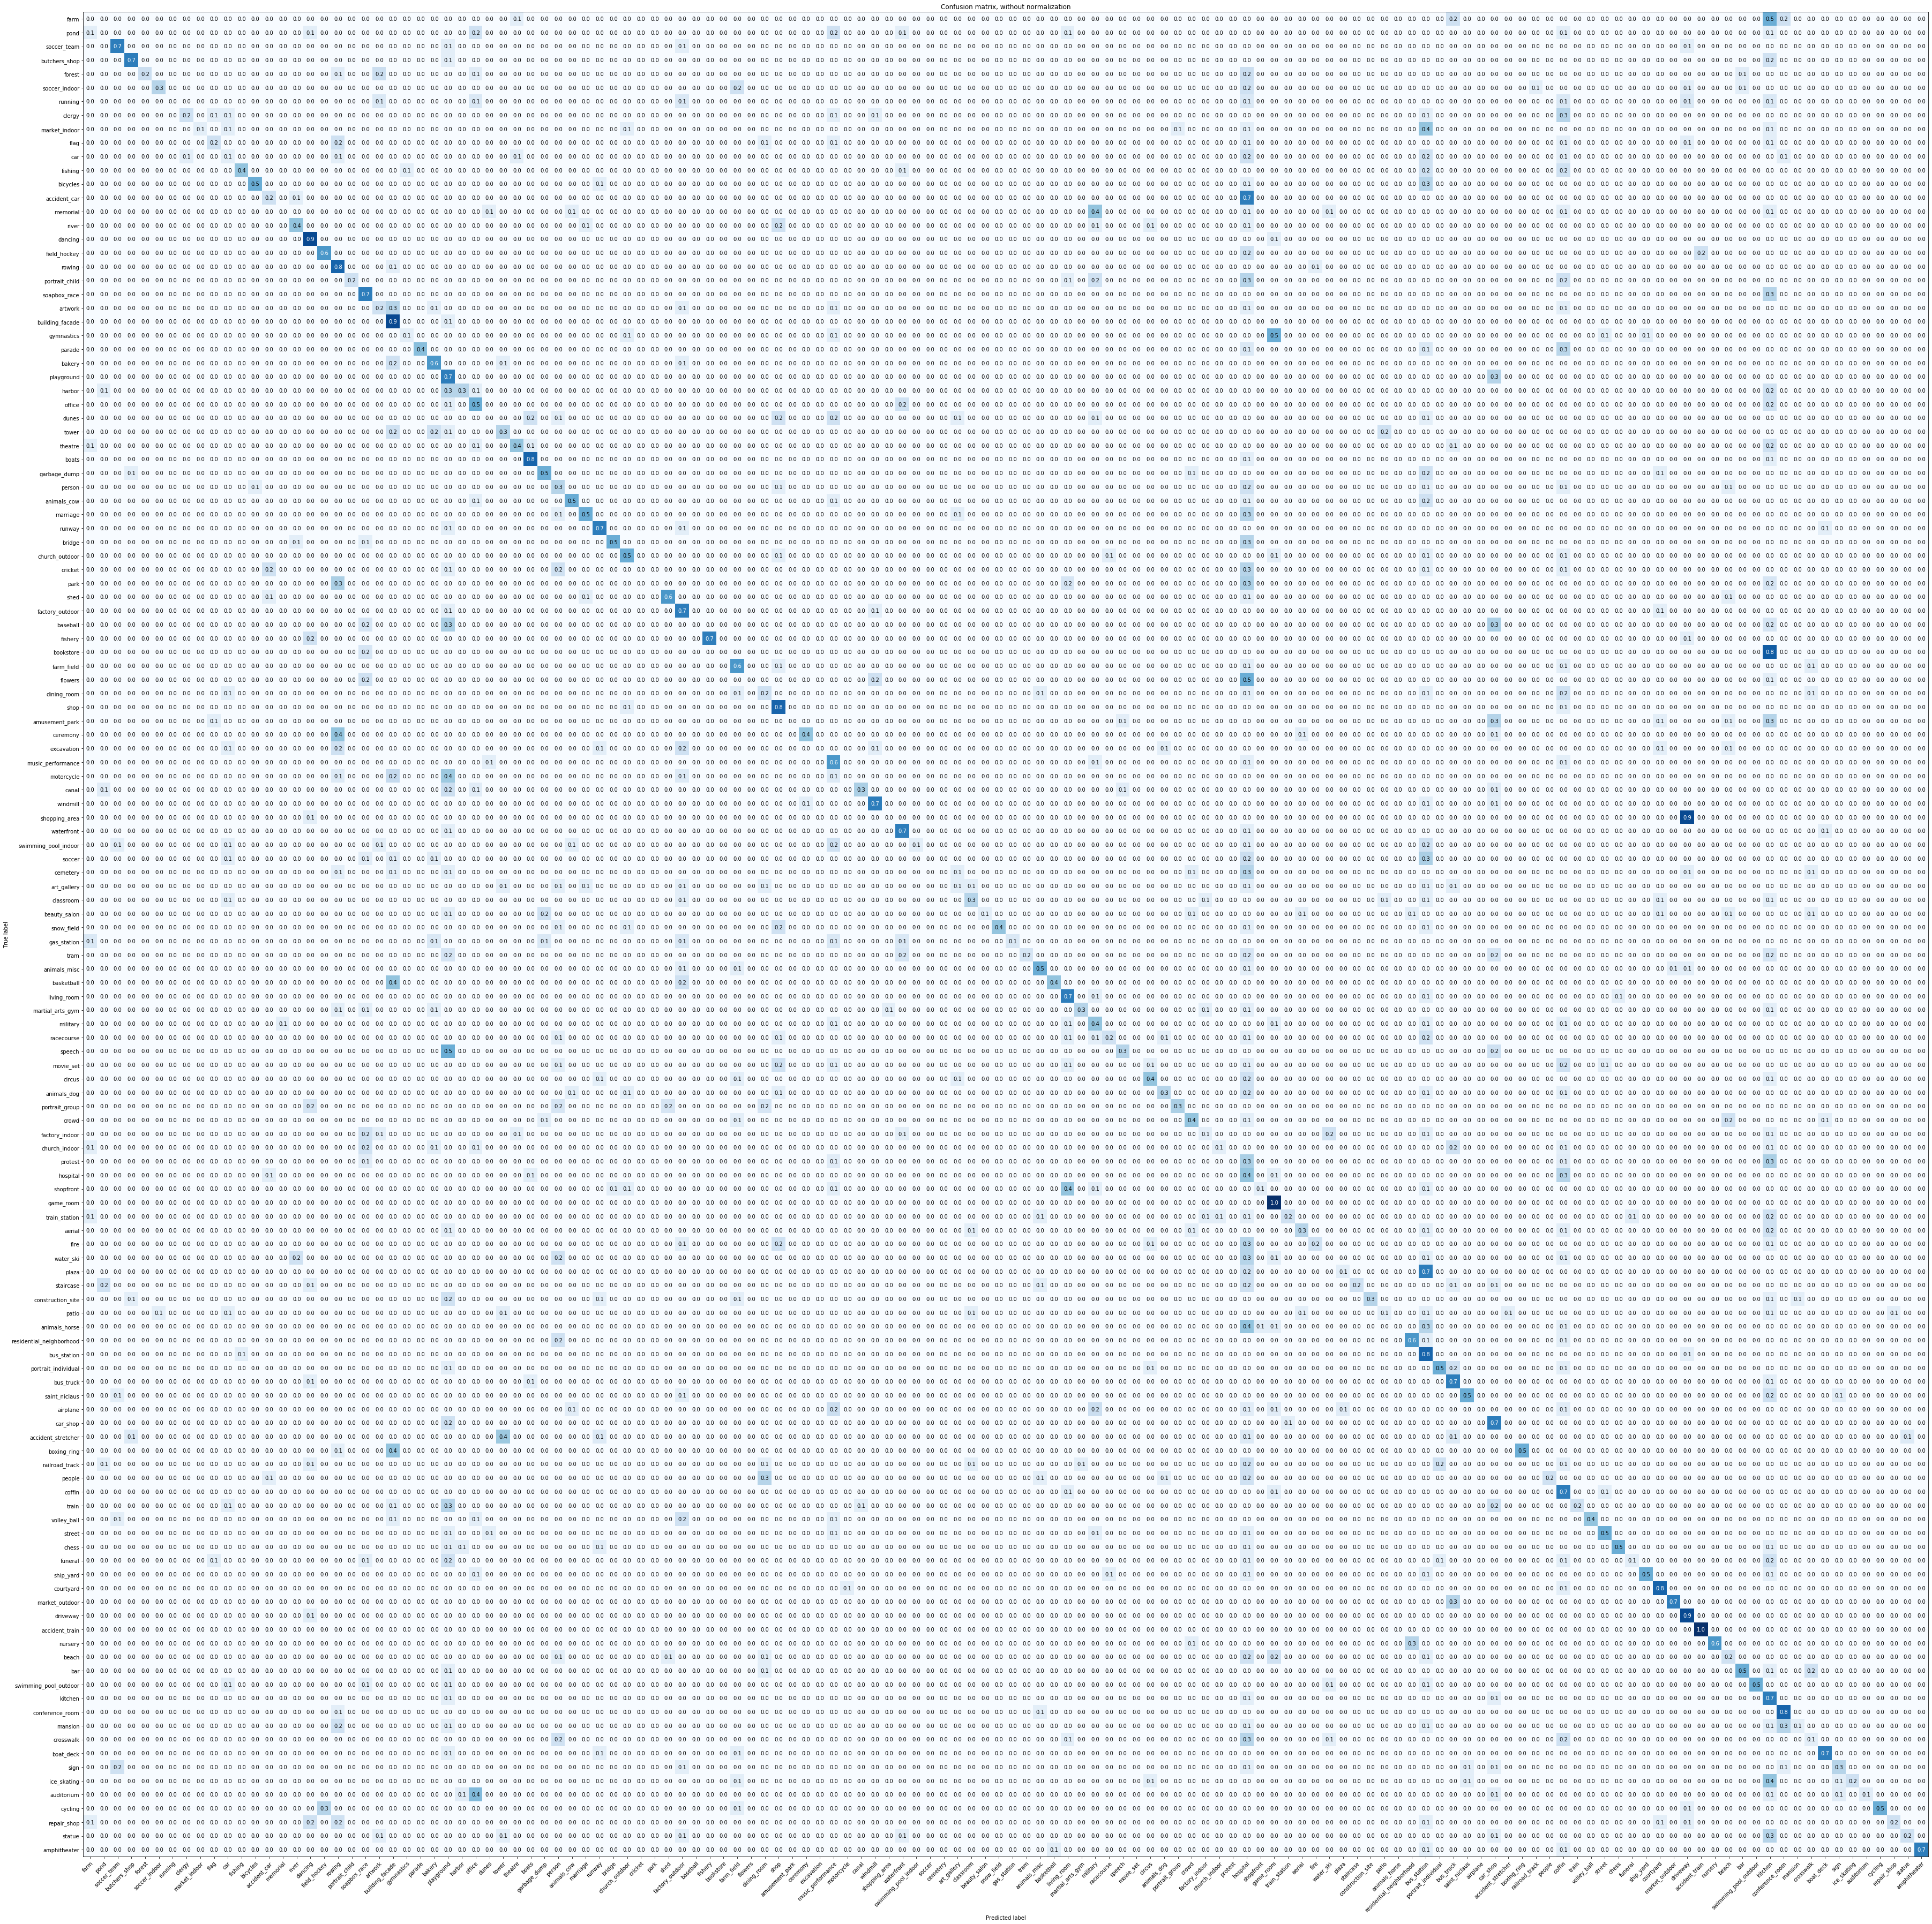

In [81]:
plot_confusion_matrix(predictions_df['y_true'], predictions_df['y_pred'], classes=categories, normalize=True, title='Confusion matrix, without normalization')

In [76]:
plt.savefig('../output/figures/confusion_matrix.png')

<Figure size 432x288 with 0 Axes>